# Load the Packages

In [1]:
try:    
    import numpy as np
    import math
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.stats import skew
    from collections import Counter
    from lmfit import Model
    import yfinance as yf
    import pywt
    import statistics
    import xgboost as xgb
    import operator
    from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
    from xgboost.sklearn import XGBRegressor

except ImportError:
    print('Error: Please install the missing package via conda')

# Introduction About the Algorithm
We investigate the tail behaviour from financial time-series data.
Our rationale is based on a power-law principle of the tail section.
Using a moving window of a fixed length in time, we first estimate the probability density function (PDF) of X, then calculate its exceedance P(x)=PDF(X>x), where x refers to either the gross return or normalized return rate of the stock price, and X is a threshold for the tail section.
If the PDF has a tail ~ \begin{equation} x^{-k(t)} \end{equation} at the forward time t, then the logarithm of the exceedance would have a tail with a linear slope \begin{equation} -k(t) \end{equation}
We choose the time-series stock price from Yahoo Finance and use our tail model to generate the corresponding time-series tail slopes.

# Define the Functions
\begin{equation}
Q(t;h)=p(t+h)-p(t),  \
q(t;h)=Q(t;h)/p(t);
\end{equation}
\begin{equation}
P^{**}=P(x>x^{**}) \geq \frac{n}{T-h}\\
P(|x^{**}| > |x| > |x^{*}|)=\gamma_{}x^{-k}
\end{equation}

In [2]:
# Gross change Q(t;h)
def delta_p_gross_func(stock, ticker_option, lead_time):
    delta_p_gross = []
    for i in range(lead_time, len(stock)):
        delta_p_i = stock[ticker_option][i]-stock[ticker_option][i-lead_time]
        delta_p_gross.append(delta_p_i)
    return delta_p_gross

# Normalized change q(t;h)
def delta_p_norm_func(stock, ticker_option, lead_time):
    delta_p_norm = []
    for i in range(lead_time, len(stock)):
        delta_p_i = (stock[ticker_option][i]-stock[ticker_option][i-lead_time])/(stock[ticker_option][i-lead_time])
        delta_p_norm.append(delta_p_i)
    return delta_p_norm

# Choose Q(t;h) or q(t;h)
def delta_p_sft_func(stock, trans, lead_time):
    global delta_p
    if trans == "Normalized Change":
        delta_p = delta_p_norm_func(stock, ticker_option, lead_time)
    elif trans == "Gross Change":
        delta_p = delta_p_gross_func(stock, ticker_option, lead_time)
    return delta_p

# Define the tail option: left, right or absolute
def delta_p_tail_option(tail_option):
    global delta_p_skewness, delta_p_skewness_count_sort
    if tail_option == "Absolute":
        delta_p_skewness = [abs(element) for element in delta_p]
        delta_p_skewness_count = Counter(delta_p_skewness)
        delta_p_skewness_count_sort = dict(sorted(delta_p_skewness_count.items(),reverse=True))
    elif tail_option == "Right":
        delta_p_skewness = [element for element in delta_p if element >= 0]
        delta_p_skewness_count = Counter(delta_p_skewness)
        delta_p_skewness_count_sort = dict(sorted(delta_p_skewness_count.items(),reverse=True))
    elif tail_option == "Left":
        delta_p_skewness = [element for element in delta_p if element < 0]
        delta_p_skewness_count = Counter(delta_p_skewness)
        delta_p_skewness_count_sort = dict(sorted(delta_p_skewness_count.items()))
    return delta_p_skewness, delta_p_skewness_count_sort

# Normalize the exceedance
def exceedance_norm(delta_p_Ex, p_value, pp_limit):
    global delta_p_Ex_norm, index_x_1, index_x_2, exceedance_y_1, exceedance_y_2, index_pp_value, pp_value_norm
    delta_p_Ex_norm = [element * int(1/p_value) for element in delta_p_Ex]
    exceedance_y_1 = min([element for element in delta_p_Ex_norm if element >= 1])
    if [element for element in delta_p_Ex_norm if element <= 1] != []:       
        exceedance_y_2 = max([element for element in delta_p_Ex_norm if element <= 1])
    else:
        exceedance_y_2 = exceedance_y_1
    index_x_1 = delta_p_Ex_norm.index(exceedance_y_1)
    index_x_2 = delta_p_Ex_norm.index(exceedance_y_2)
    pp_value = min([element for element in delta_p_Ex_norm if element >= (pp_limit/(len(delta_p))/p_value)])
    index_pp_value = delta_p_Ex_norm.index(pp_value)
    p_value_norm = 1
    pp_value_norm = pp_value/p_value_norm
    return delta_p_Ex_norm, index_x_1, index_x_2, exceedance_y_1, exceedance_y_2, index_pp_value, pp_value_norm

# Do the normalization using count bins
def bins_norm(count_bins):
    global count_bins_norm, xx_value_norm
    if exceedance_y_2 == exceedance_y_1:
        count_bins_p_value = count_bins[index_x_1]
    else:
        count_bins_p_value = count_bins[index_x_1]+(count_bins[index_x_2]-count_bins[index_x_1])/(exceedance_y_2-exceedance_y_1)*(1-exceedance_y_1)
    count_bins_norm = [element/count_bins_p_value for element in count_bins]
    x_value_norm = 1
    xx_value_norm = count_bins_norm[index_pp_value]
    return count_bins_norm, xx_value_norm

# Define the exceedance of the input variable
def delta_p_exceedance(tail_option, p_value, pp_limit):
    global delta_p_Ex, count_bins
    delta_p_Ex = []
    delta_p_tail_option(tail_option)
    count_bins = list(delta_p_skewness_count_sort.keys())
    count_values = list(delta_p_skewness_count_sort.values())
    delta_p_count = 0
    for count in count_values:           
        delta_p_count += count
        delta_p_Ex.append(delta_p_count/len(delta_p_skewness))
    exceedance_norm(delta_p_Ex, p_value, pp_limit)
    bins_norm(count_bins)

# Define the exceedance with a lead time
def exceedance_sft(stock, trans, lead_time, tail_option, p_value, pp_limit):
    delta_p_sft_func(stock, trans, lead_time)
    delta_p_exceedance(tail_option, p_value, pp_limit)
    delta_p_Ex_norm_sft = delta_p_Ex_norm
    p_value_sft = [count_bins_norm, [xx_value_norm, pp_value_norm]]
    return delta_p_Ex_norm_sft, p_value_sft

# In-In relation of the tail section
def cal_In(ser):
# ser is the exceedance series
    ser = ser.replace([np.inf,-np.inf],np.nan).dropna()
    global In_Ex, Index
    In_Ex = []
    Index = []
    for i in range(len(ser)):
        In_Ex.append(-np.log(ser.values[i]))
        Index.append(np.log(ser.index[i]))
    return In_Ex, Index

# Choose the tail section
def cut_tail(delta_p_Ex_norm_sft, p_value_sft):
    global cut_off
    df_delta_p = pd.DataFrame(delta_p_Ex_norm_sft,index=p_value_sft[0])
    cut_off = [np.log(p_value_sft[1][0]),-np.log(p_value_sft[1][1])]
    cal_In(df_delta_p)
    
# Linear fitting of the Ln-Ln tail section
def linear_fit(x, a, b):
    return a*x + b

# Calculate tail slope
def cal_slope(ser, m, n):
# ser is the exceedance series
# n is for the starting index of the series
    global k, stdev
    ser = ser[n:m]
    ser = ser.replace([np.inf,-np.inf],np.nan).dropna()
    ser_update = []
    for ser_item in ser.values.tolist():
        ser_update.append(ser_item[0])
    model = Model(linear_fit)
    model.set_param_hint('a', value=3.0)
    model.set_param_hint('b', value=0.0)
    result = model.fit(ser_update, x=ser.index.tolist())
    k = result.params['a'].value
    stdev = result.params['a'].stderr
    return k, stdev

# Estimate delta_p tail slope
def delta_p_tail_slope(delta_p_Ex_norm_sft, p_value_sft):
    cut_tail(delta_p_Ex_norm_sft, p_value_sft)
    df_tail = pd.DataFrame(In_Ex,index=Index)
    n = np.log(p_value_sft[1][0])
    m = 0.0
    cal_slope(df_tail, m, n)
    tail_points = len(df_tail[n:m])
    return k, stdev, tail_points

# Define the Rolling Windows

In [3]:
# Contiguous snippets of stock (by a rolling window)
def chunks(stock, window_size):
    snippets = int(len(stock)/window_size)
    chunks_stock = np.array_split(stock, snippets)
    chunks_list = []
    for i in range(len(chunks_stock)):
        chunks_stock[i].reset_index(drop=True, inplace=True)
        chunks_list.append(chunks_stock[i])
    win_list_raw = np.array_split(stock.index, snippets)
    win_list = []
    for i in win_list_raw:
        win_list.append(i[0])
    return chunks_list, win_list

def chunks_rolling(stock, window_size):
    # n is the rolling step
    chunks_list_rolling = []
    win_list_rolling = []
    for i in range(len(stock)):
        if i < (len(stock)-window_size):
            chunks_list_rolling.append(stock[i:(i+window_size)])
            win_list_rolling.append(stock.index[(i+window_size)])
    return chunks_list_rolling, win_list_rolling

# Input Parameters

In [4]:
ticker_option = "Adj Close" # Select "Open", "Adj Close", "High", "Low"
tail_option = "Left" # Select "Left", "Right", "Absolute"
variable = "Gross Change" # Select "Gross Change", "Normalized Change"
lead_time = 5 # Lead time in days. Input 5 actually 7 days due to the absence of data points in weekends
window_size = 4 # Rolling window size in years
window_size = round(window_size*365*5/7) # Convert window size from years to days
p_value = 0.1 # Upper limit in exceedance
pp_limit = 2 # Calculate the lower threshold in exceedance, 
              # here pp_limit refers to n in n/(T-h) of the defined functions

# Load the Stock Data From Yahoo Finance

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Time-series adjusted close price of GE')

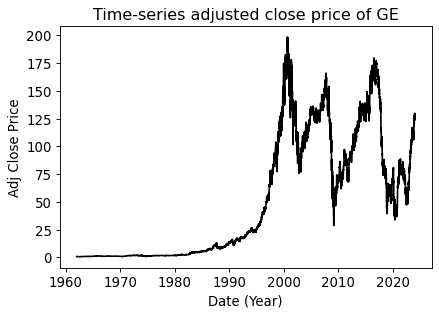

In [5]:
# Use Boeing Company's stock (BA) as an example
stock_name = 'GE'
stock = yf.download(stock_name, interval="1d")
# Plot the time-series stock price
plt.figure(figsize=(6,4), dpi=80)
plt.rcParams['font.size'] = 12
plt.plot(np.array(stock.index), np.array(stock['Adj Close']), color="black")
plt.xlabel("Date (Year)")
plt.ylabel("Adj Close Price")
plt.title("Time-series adjusted close price of "+stock_name)

# Calculate Time-Series Tail Slopes

In [6]:
stocks_name = ['GE','JPM']
tails_df = []
for stock_name in stocks_name:
    stock = yf.download(stock_name, interval="1d")
    # Build the rolling window
    (chunks_list_rolling, win_list_rolling) = chunks_rolling(stock, window_size)
    # Detect the tail slope in each rolling window
    # This calculation may take a few minutes
    t = []
    k_t = []
    for num in range(len(chunks_list_rolling)):
        Ex_sft = exceedance_sft(chunks_list_rolling[num], variable, lead_time, tail_option, p_value, pp_limit)[0]
        p_value_sft = exceedance_sft(chunks_list_rolling[num], variable, lead_time, tail_option, p_value, pp_limit)[1]
        tail_slope = delta_p_tail_slope(Ex_sft, p_value_sft)[0]
        if tail_slope < 8:
            k_t.append(tail_slope)
            t.append(win_list_rolling[num])
    tail_df = pd.DataFrame({'Date': t, 'Tail Slope': k_t})
    tails_df.append(tail_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Visualize the Tail Transitions

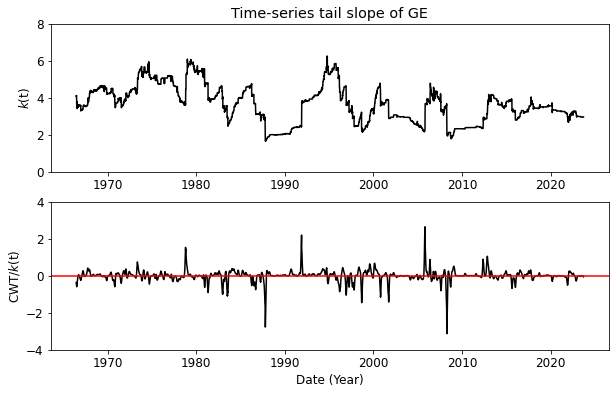

In [7]:
stock_name = 'GE' # Select stock for analysis
idx = stocks_name.index(stock_name)
t = tails_df[idx]['Date'].tolist()
k_t = tails_df[idx]['Tail Slope'].tolist()

# Wavelet transform
# 'gaus1', 'gaus6', 'gaus7', 'cgau1', 'morl'
d = 40
widths = np.arange(1,d)
wavelet = 'gaus1'
cwtmatr, freqs = pywt.cwt(k_t, widths, wavelet)

# Plot the time-series tail curve and its wavelet transform
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.plot(np.array(t[2*d:-2*d]), np.array(k_t[2*d:-2*d]), color='black')
ax1.set(ylabel=r'$k(\mathrm{t})$', title='Time-series tail slope of '+str(stock_name))
ax1.set_ylim(0,8)
ax2.plot(np.array(t[2*d:-2*d]), np.array(-cwtmatr[d//2][2*d:-2*d]/k_t[2*d:-2*d]), color='black')
ax2.set(xlabel="Date (Year)", ylabel='CWT'+'/'+r'$k(\mathrm{t})$')
ax2.set_ylim(-4,4)
ax2.axhline(0, color='r')
plt.rcParams.update({'font.size': 14})

# Define Correlation
\begin{equation}
r_{i} = \frac{\sum\limits_{t=i+1}^{T}(y_t-\hat{y})(y_{t-i}-\hat{y})}{\sum\limits_{t=1}^{T}(y_t-\hat{y})^2}
\end{equation}

In [8]:
def ser_lag_func(ser, lag):
    ser_lag = ser[lag:]
    return ser, ser_lag

def autocorrelation_func(ser, ser_lag):
    autocorrelation = np.corrcoef(ser[:len(ser_lag)], ser_lag)[0][1]
    return autocorrelation

def autocorrelation_ts_func(ser, lag_list):
    autocorrelation_ts = []
    for lag in lag_list:
        if lag >= 0:
            [ser_, ser_lag] = ser_lag_func(ser, lag)
            autocorrelation_ts.append(autocorrelation_func(ser_, ser_lag))
        if lag < 0:
            [ser_, ser_lag] = ser_lag_func(ser, -lag)
            autocorrelation_ts.append(autocorrelation_func(ser_, ser_lag))
    return autocorrelation_ts

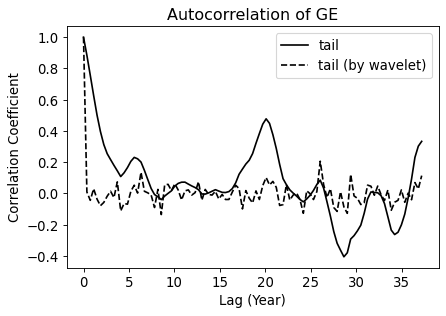

In [9]:
# Time-series autocorrelation
lag_list = list(range(0, len(k_t)*2//3, len(k_t)*2//300))
cor_ts_tail = autocorrelation_ts_func(k_t, lag_list)
cor_ts_wv = autocorrelation_ts_func(-cwtmatr[d//2][2*d:-2*d]/k_t[2*d:-2*d], lag_list)

# Plot autocorrelation for the stock itself
lag_list_year = [element/260.7 for element in lag_list]
plt.figure(figsize=(6,4), dpi=80)
plt.rcParams['font.size'] = 12
plt.plot(lag_list_year, cor_ts_tail, "k")
plt.plot(lag_list_year, cor_ts_wv, "k--")
plt.xlabel("Lag (Year)")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation of "+stock_name)
plt.legend(['tail','tail (by wavelet)'])

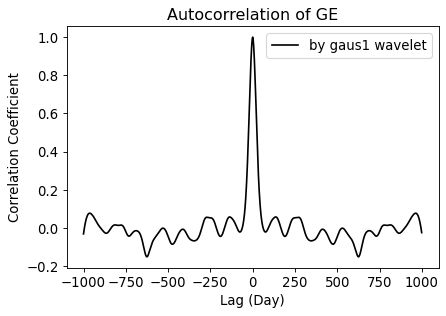

In [10]:
# Time-series autocorrelation (days)
lag_list_day = list(range(-1000, 1000))
cor_ts_wv = autocorrelation_ts_func(-cwtmatr[d//2][2*d:-2*d]/k_t[2*d:-2*d], lag_list_day)

plt.figure(figsize=(6,4), dpi=80)
plt.rcParams['font.size'] = 12
plt.plot(lag_list_day, cor_ts_wv, "k")
plt.xlabel("Lag (Day)")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation of "+stock_name)
plt.legend(['by '+str(wavelet)+' wavelet'])

# Visualize Comovements in Tails

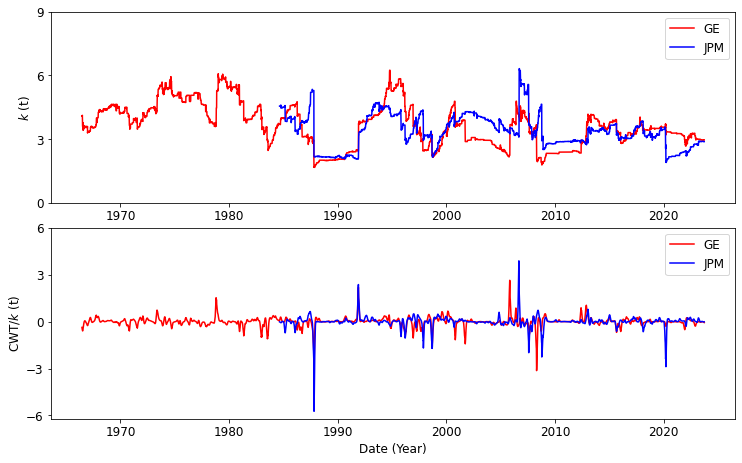

In [11]:
# Compare the stocks with common features
t1 = tails_df[stocks_name.index('GE')]['Date']
t2 = tails_df[stocks_name.index('JPM')]['Date']
k_t1 = tails_df[stocks_name.index('GE')]['Tail Slope']
k_t2 = tails_df[stocks_name.index('JPM')]['Tail Slope']
stock_name1 = stocks_name[stocks_name.index('GE')]
stock_name2 = stocks_name[stocks_name.index('JPM')]

cwtmatr1, freqs1 = pywt.cwt(k_t1, widths, 'gaus1')
cwtmatr2, freqs2 = pywt.cwt(k_t2, widths, 'gaus1')

# Plot the time-series tail curve and its wavelet transform
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
fig.tight_layout(pad=0.0)
ax1.plot(np.array(t1[2*d:-2*d]), np.array(k_t1[2*d:-2*d]), color='red', label=str(stock_name1))
ax1.plot(np.array(t2[2*d:-2*d]), np.array(k_t2[2*d:-2*d]), color='blue', label=str(stock_name2))
ax1.set(ylabel=r'$k\ (\mathrm{t})$')
ax1.set_yticks(np.arange(0,10,3))
ax1.legend()
ax2.plot(np.array(t1[2*d:-2*d]), np.array(-cwtmatr1[d//2][2*d:-2*d]/k_t1[2*d:-2*d]), color='red', label=str(stock_name1))
ax2.plot(np.array(t2[2*d:-2*d]), np.array(-cwtmatr2[d//2][2*d:-2*d]/k_t2[2*d:-2*d]), color='blue', label=str(stock_name2))
ax2.set(xlabel="Date (Year)", ylabel='CWT'+'/'+r'$k\ (\mathrm{t})$')
ax2.set_yticks(np.arange(-6,7,3))
ax2.legend()
plt.rcParams.update({'font.size': 14})

# Define Technical Indicators and Tails

In [12]:
def get_technical_indicators(dataset, dataset_precursor, lag, date_start, date_end):
    
    # Load dataset
    df_TI = pd.DataFrame({'Date': dataset['Date'], 'price': dataset['Adj Close']})
    
    # Price difference with lag
    df_TI['lag'] = df_TI['price'].shift(lag)
    
    # Create 14 days moving average
    df_TI['MA14'] = df_TI['lag'].rolling(window=10).mean()

    # Create Bollinger bands
    df_TI['SD14'] = df_TI['lag'].rolling(window=10).std()
    df_TI['Upper Band'] = df_TI['MA14'] + (df_TI['SD14'])
    df_TI['Lower Band'] = df_TI['MA14'] - (df_TI['SD14'])
    
    # Create exponential moving average
    df_TI['EMA'] = df_TI['lag'].ewm(com=0.5).mean()
    
    # Load precursor dataset
    # Wavelet transform
    # 'db2', ‘haar’, 'gaus1’, ‘mexh’, ‘morl’, ‘cgau1’
    t = dataset_precursor['Date'].tolist()
    k_t = dataset_precursor['Tail Slope'].tolist()

    d = 40
    widths = np.arange(1,d)
    wavelet = 'gaus1'
    cwtmatr, freqs = pywt.cwt(k_t, widths, 'gaus1')
    df_CWT_norm = pd.DataFrame({'Date': t[2*d:-2*d], 'cwt_k': -cwtmatr[d//2][2*d:-2*d]/k_t[2*d:-2*d]})
    
    # Combine the dataset
    df_TI.set_index('Date', inplace=True)
    df_TI.index = pd.to_datetime(df_TI.index, utc=True)
    df_TI = df_TI[lag:]
    df_CWT_norm.set_index('Date', inplace=True)
    df_CWT_norm.index = pd.to_datetime(df_CWT_norm.index, utc=True)
    df_CWT_norm['cwt_k'] = df_CWT_norm['cwt_k'].shift(lag)
    df_ML = df_TI.join(df_CWT_norm, how='outer')
    df_ML = df_ML[(df_ML.index >= date_start) & (df_ML.index <= date_end)]

    return df_ML

# Build the Dataframe for XGBoost

In [13]:
GE = yf.download('GE', interval="1d")

# Create the dataset for ML
dataset = GE.reset_index() # GE as the target
dataset_precursor = tails_df[stocks_name.index('JPM')] # JPM as the precursor for GE
lag = 1 # lag time for the prediction
date_start = '1985-01-01'
date_end = '2023-01-01'
df_ML = get_technical_indicators(dataset, dataset_precursor, lag, date_start, date_end)

[*********************100%***********************]  1 of 1 completed


# Define Data Processing for XGBoost

In [14]:
def xgb_data_split(df, bucket_size, unseen_start_date, steps, test_start_date, target_name):
    # Generate unseen data
    unseen = get_unseen_data(unseen_start_date, steps,
                             bucket_size, target_name)
    df = pd.concat([df, unseen], axis=0)
    df.index = pd.to_datetime(df.index, utc=True)

    # Data for forecast, skip the connecting point
    df_unseen = df[unseen_start_date:].iloc[:, 1:]
    # Skip the connecting point
    df_test = df[test_start_date: unseen_start_date].iloc[:-1, :]
    df_train = df[:test_start_date]
    return df_unseen, df_test, df_train

def feature_importance_plot(importance_sorted, title):
    df = pd.DataFrame(importance_sorted, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    plt.figure()
    # df.plot()
    df.plot(kind='barh', x='feature', y='fscore',
            legend=False, figsize=(12, 14))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('F-Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    # plt.savefig(title + '.png', dpi=300)
    plt.show()

def xgb_importance(df, test_ratio, xgb_params, ntree, early_stop, plot_title):
    df = pd.DataFrame(df)
    # Split the data into train/test set
    Y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_ratio,
                                                        random_state=42)

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'validate')]

    xgb_model = xgb.train(xgb_params, dtrain, ntree, evals=watchlist,
                          early_stopping_rounds=early_stop, verbose_eval=True)

    importance = xgb_model.get_fscore()
    importance_sorted = sorted(importance.items(), key=operator.itemgetter(1))
    feature_importance_plot(importance_sorted, plot_title)

def xgb_forecasts_plot(plot_start, Y, Y_test, Y_hat, forecasts, forecasts_plot, title):
    Y = pd.concat([Y, Y_test])
    ax = Y[plot_start:].plot(label='Observed', figsize=(12, 8))
    # Y_test.plot(label='Test Observed', ax=ax)
    Y_hat.plot(label="Predicted", ax=ax)
    if forecasts_plot == "YES":
        forecasts.plot(label="Forecast", ax=ax)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(Y_test.index[0]), Y_test.index[-1],
                     alpha=.1, zorder=-1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Gross Change')
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=0)
    # plt.savefig(title + '.png', dpi=300)
    plt.show()

def preprocess(N_rows, parse_dates, filename):
    total_rows = sum(1 for l in open(filename))
    variable_names = pd.read_csv(
        filename, header=0, delimiter=";", nrows=5)
    df = pd.read_csv(filename, header=0, delimiter=';', names=variable_names.columns,
                     parse_dates=parse_dates, index_col=0, nrows=N_rows, skiprows=total_rows - N_rows)
    df_no_na = df.replace('?', np.NaN)
    df_no_na.dropna(inplace=True)
    return df_no_na.astype(float)


def timeseries_plot(y, color, y_label):
    # y is Series with index of datetime
    days = dates.DayLocator()
    dfmt_minor = dates.DateFormatter('%m-%d')
    weekday = dates.WeekdayLocator(byweekday=(), interval=1)
    fig, ax = plt.subplots()
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_minor_formatter(dfmt_minor)
    ax.xaxis.set_major_locator(weekday)
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a'))
    ax.set_ylabel(y_label)
    ax.plot(np.array(y.index), np.array(y), color)
    fig.set_size_inches(10, 6)
    plt.tight_layout()
    plt.show()

def bucket_avg(ts, bucket):
    # ts is Sereis with index
    # bucket =["30T","60T","M".....]
    y = ts.resample(bucket).mean()
    return y

def config_plot():
    plt.style.use('seaborn-paper')
    plt.rcParams.update({'axes.titlesize': 20})
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams.update({'axes.labelsize': 22})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'figure.figsize': (10, 6)})
    plt.rcParams.update({'legend.fontsize': 20})
    return 1

def get_unseen_data(unseen_start, steps, bucket_size, target_name):
    index = pd.date_range(unseen_start,
                          periods=steps, freq=bucket_size)
    df = pd.DataFrame(pd.Series(np.zeros(steps), index=index),
                      columns=[target_name])
    return df

def data_add_timesteps(data, column, lag):
    column = data[column]
    step_columns = [column.shift(i) for i in range(2, lag + 1, 2)]
    df_steps = pd.concat(step_columns, axis=1)
    # Current Global_active_power is at first columns
    df = pd.concat([data, df_steps], axis=1)
    return df

# Build XGBoost for Machine Learning

In [15]:
# Input features for XGBoost
bucket_size = "1D"
features_main = df_ML[['price','lag','cwt_k','MA14','EMA','SD14']]
target_name = 'price'

df = pd.DataFrame(bucket_avg(features_main, bucket_size))
df.dropna(inplace=True)

test_start_date = '2010-12-31 00:00:00'
unseen_start_date = '2018-01-01 00:00:00'
steps = 0 # Number of days for forecasting

# Get splited data
df_unseen, df_test, df = xgb_data_split(
    df, bucket_size, unseen_start_date, steps, test_start_date, target_name)
print('\n-----XGBoost on only datetime information-----\n')

dim = {'train and validation data ': df.shape,
       'test data ': df_test.shape,
       'forecasting data ': df_unseen.shape}
print(pd.DataFrame(list(dim.items()), columns=['Data', 'dimension']))


-----XGBoost on only datetime information-----

                         Data  dimension
0  train and validation data   (6558, 6)
1                  test data   (1761, 6)
2           forecasting data   (1259, 5)


-----XGBoost using all numeric features----- 
---inital model feature importance---
[0]	train-rmse:79.00898	validate-rmse:76.16623
[1]	train-rmse:71.16751	validate-rmse:68.60934
[2]	train-rmse:64.10274	validate-rmse:61.80661
[3]	train-rmse:57.73799	validate-rmse:55.66850
[4]	train-rmse:52.00140	validate-rmse:50.13728
[5]	train-rmse:46.84716	validate-rmse:45.16740
[6]	train-rmse:42.19939	validate-rmse:40.67705
[7]	train-rmse:38.01742	validate-rmse:36.64253
[8]	train-rmse:34.25146	validate-rmse:33.01159
[9]	train-rmse:30.86189	validate-rmse:29.74148
[10]	train-rmse:27.80433	validate-rmse:26.78912
[11]	train-rmse:25.05266	validate-rmse:24.12982
[12]	train-rmse:22.57680	validate-rmse:21.73638
[13]	train-rmse:20.34709	validate-rmse:19.58267
[14]	train-rmse:18.33940	validate-rmse:17.65081
[15]	train-rmse:16.53399	validate-rmse:15.91144
[16]	train-rmse:14.90806	validate-rmse:14.34309
[17]	train-rmse:13.44729	validate-rmse:12.93628
[18]	train-rmse:12.13165	validate-rmse:11.66956
[19]	train-rms

[175]	train-rmse:0.39142	validate-rmse:1.67774
[176]	train-rmse:0.38938	validate-rmse:1.67784
[177]	train-rmse:0.38616	validate-rmse:1.67866
[178]	train-rmse:0.38379	validate-rmse:1.67872
[179]	train-rmse:0.37914	validate-rmse:1.67893
[180]	train-rmse:0.37737	validate-rmse:1.67884
[181]	train-rmse:0.37576	validate-rmse:1.67915
[182]	train-rmse:0.37449	validate-rmse:1.67904
[183]	train-rmse:0.37165	validate-rmse:1.67922
[184]	train-rmse:0.36780	validate-rmse:1.67931
[185]	train-rmse:0.36578	validate-rmse:1.67958
[186]	train-rmse:0.36386	validate-rmse:1.67945
[187]	train-rmse:0.36192	validate-rmse:1.67973
[188]	train-rmse:0.35922	validate-rmse:1.68038
[189]	train-rmse:0.35547	validate-rmse:1.68063
[190]	train-rmse:0.35318	validate-rmse:1.68076
[191]	train-rmse:0.35156	validate-rmse:1.68145
[192]	train-rmse:0.34964	validate-rmse:1.68094
[193]	train-rmse:0.34721	validate-rmse:1.68055
[194]	train-rmse:0.34536	validate-rmse:1.68051
[195]	train-rmse:0.34312	validate-rmse:1.68083
[196]	train-r

<Figure size 432x288 with 0 Axes>

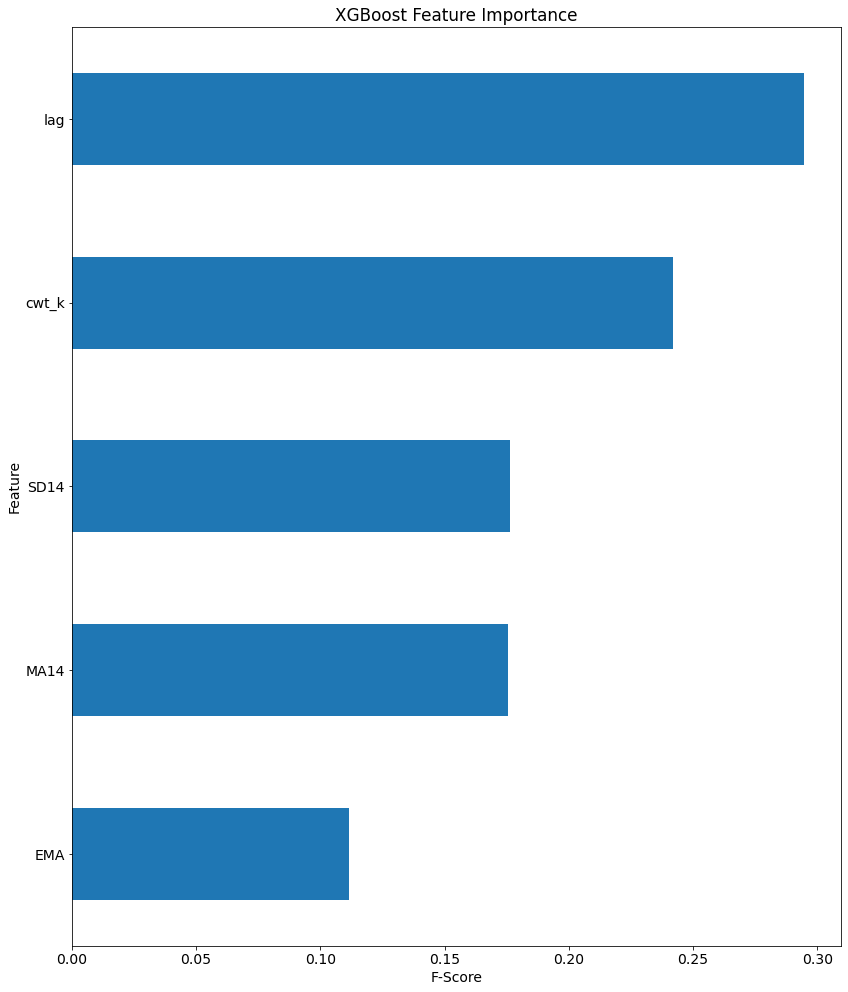

In [16]:
# Base parameters
xgb_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',  # Regression task
    'subsample': 0.80,  # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85,  # 85% of features used
    'eta': 0.1,
    'max_depth': 10,
    'seed': 42}  # for reproducible results

val_ratio = 0.3
ntree = 300
early_stop = 150

print('-----XGBoost using all numeric features-----',
      '\n---inital model feature importance---')
      
fig_allFeatures = xgb_importance(
    df, val_ratio, xgb_params, ntree, early_stop, 'All Features')
    
plt.show()

##############################################################################
# Run XGBoost on all features
# Get data
# Train model
Y = df.iloc[:, 0]
X = df.iloc[:, 1:]
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=val_ratio,
                                                  random_state=42)

X_test = xgb.DMatrix(df_test.iloc[:, 1:])
Y_test = df_test.iloc[:, 0]
X_unseen = xgb.DMatrix(df_unseen)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
watchlist = [(dtrain, 'train'), (dval, 'validate')]

# Data Forecasting

[0]	train-rmse:79.00898	validate-rmse:76.16623
[1]	train-rmse:71.16751	validate-rmse:68.60934
[2]	train-rmse:64.10274	validate-rmse:61.80661
[3]	train-rmse:57.73799	validate-rmse:55.66850
[4]	train-rmse:52.00140	validate-rmse:50.13728
[5]	train-rmse:46.84716	validate-rmse:45.16740
[6]	train-rmse:42.19939	validate-rmse:40.67705
[7]	train-rmse:38.01742	validate-rmse:36.64253
[8]	train-rmse:34.25146	validate-rmse:33.01159
[9]	train-rmse:30.86189	validate-rmse:29.74148
-----XGBoost Using Datetime Features Only------ 
---Forecasting from Initial---


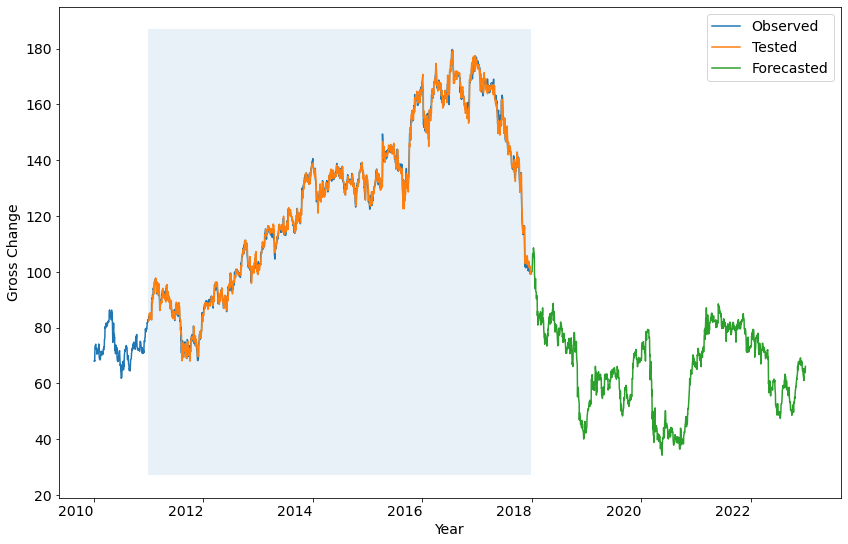

In [17]:
# Forcasting
# Prediction to testing data

config_plot

forecasts_plot = "YES"
model_final = xgb.train(xgb_params, dtrain, evals=watchlist,
                        early_stopping_rounds=early_stop, verbose_eval=True)

Y_hat = model_final.predict(X_test)
Y_hat = pd.DataFrame(Y_hat, index=Y_test.index, columns=["Tested"])

# Forcasts results using initial model
xgb_model = xgb.train(xgb_params, dtrain, ntree, evals=watchlist,
                      early_stopping_rounds=early_stop, verbose_eval=False)
Y_hat = xgb_model.predict(X_test)
Y_hat = pd.DataFrame(Y_hat, index=Y_test.index, columns=["Tested"])
unseen_y = xgb_model.predict(X_unseen)
forecasts = pd.DataFrame(
    unseen_y, index=df_unseen.index, columns=["Forecasted"])
plot_start = '2010-01-01 00:00:00'

# Plot forcast results using initial model
print('-----XGBoost Using Datetime Features Only------',
      '\n---Forecasting from Initial---')
forecasts_plot_initial = xgb_forecasts_plot(
    plot_start, Y, Y_test, Y_hat, forecasts, forecasts_plot, 'Initial Model')